In [1]:
import pandas as pd
import gzip
import bz2
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import pytricia
from datetime import datetime
from matplotlib.colors import LogNorm, Normalize
from IPython.display import display
import matplotlib.cm as cm
import radix
import itertools
import json
import pickle

### Loading AS2Org snapshot (from 20230701)

In [12]:
# Load AS2ORG
orgid_map = dict()
orgname_map = dict()
ccid_map = dict()
sourceid_map = dict()
asno_map = dict()

with gzip.open('../20230701.as-org2info.txt.gz') as f:
    for line in f:
        line = line.decode()
        if line.startswith('#'):
            continue
        entry = line.split('|')
        if len(entry) == 5:
            # Org ID --> Name, CC, Source
            orgid_map[entry[0]] = entry[0]
            orgname_map[entry[0]] = entry[2]
            ccid_map[entry[0]] = entry[3]
            sourceid_map[entry[0]] = entry[4].rstrip()
        elif len(entry) == 6:
            # AS number entry
            asno_map[entry[0]] = entry[3]

as_map_org = dict()
as_map_orgname = dict()
as_map_cc = dict()
as_map_source = dict()

for k, v in asno_map.items():
    as_map_org[k] = orgid_map[v]
    as_map_orgname[k] = orgname_map[v]
    as_map_cc[k] = ccid_map[v]
    as_map_source[k] = sourceid_map[v]

### Loading AS-relationship dataset from 20230701

In [14]:
# Load AS-REL
cust_map = defaultdict(set)
parent_map = defaultdict(set)
peer_map = defaultdict(set)

with bz2.open('../20230701.as-rel.txt.bz2') as f:
    for line in f:
        line = line.decode().strip()
        if line.startswith('#'):
            continue
        rel = line.split('|')
        if rel[2] == '-1':
            cust_map[rel[0]].add(rel[1])
            parent_map[rel[1]].add(rel[0])
        elif rel[2] == '0':
            peer_map[rel[0]].add(rel[1])
            peer_map[rel[1]].add(rel[0])

## Comparing authoritative and non-authoritative IRRs

In [3]:
# TODO: For longitudinal data
non_auth = ['altdb', 'radb']
auth = ['apnic', 'afrinic', 'arin', 'ripe', 'lacnic']
nonauth4 = []
auth4 = []

for db in non_auth:
    routes = glob.glob('../longitudinal4/{}/*route*.json.gz'.format(db))
    for f in routes:
        if 'route6' not in f:
            nonauth4.append(f)

for db in auth:
    routes = glob.glob('../longitudinal4/{}/*route*.json.gz'.format(db))
    for f in routes:
        if 'route6' not in f:
            auth4.append(f)

In [4]:
irr = ['afrinic', 'jpirr', 'canarie', 'apnic', 'arin-nonauth', 'level3', 'nestegg', 'bboi', 'idnic', 'wcgdb', 'rgnet', 'tc', 'lacnic', 'ripe-nonauth', 'openface', 'panix', 'arin', 'radb', 'altdb', 'ripe', 'nttcom']
all_irr = []
for db in irr:
    routes = glob.glob('../longitudinal4/{}/*route*.json.gz'.format(db))
    for f in routes:
        if 'route6' not in f:
            all_irr.append(f)

In [5]:
# Load all datasets to memory
auth_fp = dict()
nonauth_fp = dict()
for ele in auth4:
    name = ele.split('/')[-2]
    df = pd.read_json(ele, lines=True)
    df = df.astype(str)
    auth_fp[name] = df

for ele in nonauth4:
    name = ele.split('/')[-2]
    df = pd.read_json(ele, lines=True)
    df = df.astype(str)
    nonauth_fp[name] = df

In [6]:
other_fp = dict()

for ele in all_irr:
    if ele not in auth4 and ele not in nonauth4:
        name = ele.split('/')[-2]
        df = pd.read_json(ele, lines=True)
        df = df.astype(str)
        other_fp[name] = df

In [7]:
all_fp = dict()
all_fp.update(auth_fp)
all_fp.update(nonauth_fp)
all_fp.update(other_fp)

In [8]:
for k in all_fp:
    print(k, len(all_fp[k]))

apnic 743684
afrinic 113526
arin 137253
ripe 890755
lacnic 118599
altdb 28960
radb 1790973
jpirr 48785
canarie 2902
arin-nonauth 66126
level3 199692
nestegg 4
bboi 978
idnic 6473
wcgdb 119204
rgnet 44
tc 27884
ripe-nonauth 54841
panix 40
nttcom 511886


### Helper functions

In [9]:
def label_AS_rel(df, lhs, rhs):
    dfc = df.copy()
    for i, row in df.iterrows():
        # if row['org_cmp'] == True or row['origin_cmp'] == True:
        #     dfc.loc[i, 'rel'] = 'rel'
        #     continue
        if str(row[rhs]) in cust_map[row[lhs]]:
            dfc.loc[i, 'rel'] = 'customer'
        elif str(row[lhs]) in cust_map[row[rhs]]:
            dfc.loc[i, 'rel'] = 'customer'
        elif row[rhs] in peer_map[row[lhs]]:
            dfc.loc[i, 'rel'] = 'peer'
        elif row[lhs] in peer_map[row[rhs]]:
            dfc.loc[i, 'rel'] = 'peer'
        else:
            dfc.loc[i, 'rel'] = 'norel'
    return dfc

In [10]:
def lookup_AS(prefix_trie, prefix): #List
    try:
        return prefix_trie.get_keys(prefix)
    except KeyError:
        return []

### Comparing nonauth-IRR to auth-IRR (Section n in paper)

In [15]:
def diff_auth_nonauth(nonauth_df, auth_df):
    # Some cleaning up
    auth_df['origin'] = auth_df['origin'].str.upper()
    auth_df['origin'] = auth_df['origin'].str.replace('AS','')
    auth_df['source'] = auth_df['source'].str.upper()
    nonauth_df['origin'] = nonauth_df['origin'].str.upper()
    nonauth_df['origin'] = nonauth_df['origin'].str.replace('AS','')
    nonauth_df['source'] = nonauth_df['source'].str.upper()

    auth_df = auth_df[['route', 'origin', 'source', 'start_date', 'end_date']]
    nonauth_df = nonauth_df[['route', 'origin', 'source', 'start_date', 'end_date']]
    rtree = radix.Radix()
    
    # For every prefix in nonauth IRR, find its covering prefix in auth IRR
    for r in auth_df.route.unique():
        try:
            rnode = rtree.add(r)
        except:
            print('error', r)
    cover_merge = []
    for r in nonauth_df.route.unique():
        rnode = rtree.search_covering(r)
        if len(rnode) > 0:
            for j in rnode:
                cover_merge.append([r, j.prefix])
    cover_df = pd.DataFrame(cover_merge, columns=['nonauth', 'auth'])
    cover_df = cover_df.merge(nonauth_df, left_on=['nonauth'], right_on=['route'])
    cover_df = cover_df.merge(auth_df, left_on=['auth'], right_on=['route'], suffixes=('_nonauth', '_auth'))
    
    # housekeeping: drop duplicate rows
    cover_df = cover_df.drop(['route_nonauth', 'route_auth'], axis='columns')

    # drop rows that don't intersect in time
    cover_df = cover_df[(cover_df['start_date_nonauth'] <= cover_df['end_date_auth']) & (cover_df['start_date_auth'] <= cover_df['end_date_nonauth'])]
    
    # We mark these rows in nonauth as not sus, because they match with SOME covering prefix on the origin
    cover_match = cover_df[cover_df['origin_nonauth'] == cover_df['origin_auth']]
    cover_match = cover_match.assign(sus=lambda x: False)
    cover_merge = cover_match[['nonauth', 'origin_nonauth', 'sus']]
    cover_merge = cover_merge.drop_duplicates()
    
    # Consider everything that mismatched, and exclude those which had a match (and deemed not sus)
    cover_mismatch = cover_df[cover_df['origin_nonauth'] != cover_df['origin_auth']]

    # Cover match 
    non_sus_merge = cover_mismatch.merge(cover_merge, left_on=['nonauth', 'origin_nonauth'], right_on=['nonauth', 'origin_nonauth'], how='left')  
    sus_rows = non_sus_merge[non_sus_merge['sus'].isna()]
        
    # Filter down - further
    sus_rows = sus_rows.copy(deep=True)
    sus_rows['org_nonauth'] = sus_rows['origin_nonauth'].map(as_map_org)
    sus_rows['org_auth'] = sus_rows['origin_auth'].map(as_map_org)
    sus_rows['orgname_nonauth'] = sus_rows['origin_nonauth'].map(as_map_orgname)
    sus_rows['orgname_auth'] = sus_rows['origin_auth'].map(as_map_orgname)
    sus_rows['org_match'] = sus_rows.apply(lambda row: True if row['org_auth'] == row['org_nonauth'] else False, axis=1)
    sus_rows['org_match_name'] = sus_rows.apply(lambda row: True if str(row['orgname_auth']).upper() == str(row['orgname_nonauth']).upper() else False, axis=1)
            
    # Filter based on AS relationship (retain only those with no relationship)
    label_cover_merge = label_AS_rel(sus_rows, 'origin_nonauth', 'origin_auth')
    
    # Final output
    output = label_cover_merge[(label_cover_merge['org_match'] == False) & (label_cover_merge['org_match_name'] == False) & (label_cover_merge['rel'] == 'norel')]
    return output
        
return_l = diff_auth_nonauth(nonauth_fp['altdb'], auth_fp['lacnic'])
return_l

,nonauth,auth,origin_nonauth,source_nonauth,start_date_nonauth,end_date_nonauth,origin_auth,source_auth,start_date_auth,end_date_auth,sus,org_nonauth,org_auth,orgname_nonauth,orgname_auth,org_match,org_match_name,rel
776,170.233.28.0/22,170.233.28.0/22,3549,ALTDB,2021-11-08,2023-04-20,264738,LACNIC,2023-01-25,2023-04-15,NaN,LPL-141-ARIN,@aut-264738-LACNIC,"Level 3 Parent, LLC",Sebastian Souto (SSSERVICIOS),False,False,norel
777,170.233.28.0/22,170.233.28.0/22,3549,ALTDB,2021-11-08,2023-04-20,264738,LACNIC,2023-04-16,2023-04-16,NaN,LPL-141-ARIN,@aut-264738-LACNIC,"Level 3 Parent, LLC",Sebastian Souto (SSSERVICIOS),False,False,norel
778,170.233.28.0/22,170.233.28.0/22,3549,ALTDB,2021-11-08,2023-04-20,264738,LACNIC,2023-04-17,2023-05-01,NaN,LPL-141-ARIN,@aut-264738-LACNIC,"Level 3 Parent, LLC",Sebastian Souto (SSSERVICIOS),False,False,norel


### Run comparison for auth and non-auth separately

In [27]:
def compare_dbs(auth_fp, nonauth):
    total = []
    auth_keys = auth_fp.keys()
    auth_sorted = sorted(auth_keys)
    for k in auth_sorted:
        print(k)
        output = diff_auth_nonauth(nonauth_fp[nonauth], auth_fp[k])
        total.append(output)
    merged = pd.concat(total)
    merged.to_csv('sus_altdb_cover.csv')

altdb4_l = compare_dbs(auth_fp, 'altdb')

afrinic
apnic
arin
lacnic
ripe
error 91.207.181.0/24
+
+


In [ ]:
def compare_dbs(auth_fp, nonauth):
    total = []
    auth_keys = auth_fp.keys()
    auth_sorted = sorted(auth_keys)
    for k in auth_sorted:
        print(k)
        output = diff_auth_nonauth(nonauth_fp[nonauth], auth_fp[k])
        total.append(output)
    merged = pd.concat(total)
    merged.to_csv('sus_radb_cover.csv')

radb4_l = compare_dbs(auth_fp, 'radb')

afrinic
apnic


## IRR baseline characteristics

In [37]:
def compare_two_db(left, right, diff=True):
    if left.empty or right.empty:
        return 0, 0
    left['origin'] = left['origin'].str.upper()
    left['origin'] = left['origin'].str.replace('AS','')
    left['source'] = left['source'].str.upper()
    right['origin'] = right['origin'].str.upper()
    right['origin'] = right['origin'].str.replace('AS','')
    right['source'] = right['source'].str.upper()
    
    if 'last-modified' in left.columns:
        if not left['last-modified'].isnull().values.any():
            left['changed'] = left['last-modified']
    if 'last-modified' in right.columns:
        if not right['last-modified'].isnull().values.any():
            right['changed'] = right['last-modified']
    
    left = left[['route', 'origin', 'source', 'changed']]
    right = right[['route', 'origin', 'source', 'changed']]
    right_grp = right.groupby('route').agg({'origin': set, 'source': 'first', 'changed': 'first'})
    merge_df = pd.merge(left, right_grp, on='route', how='inner')

    before = len(merge_df.drop_duplicates(subset=['route', 'origin_x']))
    
    # If the origin is not included, retain it as a potential 'phishy' entry
    # Stricter check: Use '!=' without groupby
    mask = merge_df.apply(lambda row: row['origin_x'] not in row['origin_y'], axis=1)
    filter_df = merge_df[mask]

    after = len(filter_df.drop_duplicates(subset=['route', 'origin_x']))

    return before, after

before, after = compare_two_db(all_fp['apnic'], all_fp['altdb'])
print(before)
print(after)

before, after = compare_two_db(all_fp['altdb'], all_fp['apnic'])
print(before)
print(after)

358
125
324
91


In [38]:
# Do an exact match on route objects (a covering prefix match doesn't make much sense)

def compare_db_baseline(all_fp):
    denom = dict()
    dissimilar = dict()
    keys = list(all_fp.keys())
    sorted_r = sorted(keys)        
    print(sorted_r)
    for l in sorted_r:
        for r in sorted_r:
            if l == r:
                continue
            print(l, r)
            l_fp = all_fp[l]
            r_fp = all_fp[r]
            before, after = compare_two_db(l_fp, r_fp)
            l_label = l.replace('-nonauth', '-NA')
            r_label = r.replace('-nonauth', '-NA')
            l_label = l_label.upper()
            r_label = r_label.upper()
            denom[(l_label, r_label)] = before
            dissimilar[(l_label, r_label)] = after
    return denom, dissimilar

denom, dissimilar = compare_db_baseline(all_fp)

['afrinic', 'altdb', 'apnic', 'arin', 'arin-nonauth', 'bboi', 'canarie', 'idnic', 'jpirr', 'lacnic', 'level3', 'nestegg', 'nttcom', 'openface', 'panix', 'radb', 'rgnet', 'ripe', 'ripe-nonauth', 'tc', 'wcgdb']
afrinic altdb
afrinic apnic
afrinic arin
afrinic arin-nonauth
afrinic bboi
afrinic canarie
afrinic idnic
afrinic jpirr
afrinic lacnic
afrinic level3
afrinic nestegg
afrinic nttcom
afrinic openface
afrinic panix
afrinic radb
afrinic rgnet
afrinic ripe
afrinic ripe-nonauth
afrinic tc
afrinic wcgdb
altdb afrinic
altdb apnic
altdb arin
altdb arin-nonauth
altdb bboi
altdb canarie
altdb idnic
altdb jpirr
altdb lacnic
altdb level3
altdb nestegg
altdb nttcom
altdb openface
altdb panix
altdb radb
altdb rgnet
altdb ripe
altdb ripe-nonauth
altdb tc
altdb wcgdb
apnic afrinic
apnic altdb
apnic arin
apnic arin-nonauth
apnic bboi
apnic canarie
apnic idnic
apnic jpirr
apnic lacnic
apnic level3
apnic nestegg
apnic nttcom
apnic openface
apnic panix
apnic radb
apnic rgnet
apnic ripe
apnic ripe-nonau

### Store comparison data

In [40]:
# Store the dictionary in a file
with open('denom.pickle', 'wb') as file:
    pickle.dump(denom, file)
    
with open('dissimilar.pickle', 'wb') as file:
    pickle.dump(dissimilar, file)


In [3]:
# Load denom.pickle

with open('denom.pickle', 'rb') as file:
    denom = pickle.load(file)

with open('dissimilar.pickle', 'rb') as file:
    dissimilar = pickle.load(file)


### Plot heatmaps

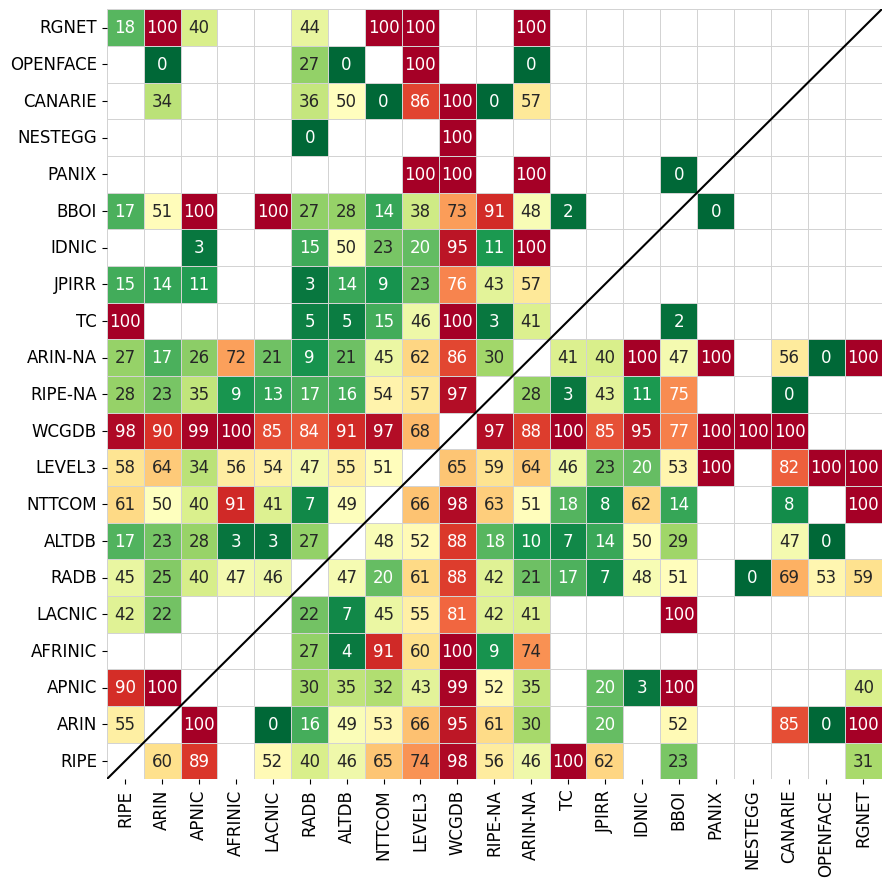

In [4]:
categories=['RIPE', 'ARIN', 'APNIC', 'AFRINIC', 'LACNIC', 'RADB', 'ALTDB', 'NTTCOM', 'LEVEL3', 'WCGDB',
'RIPE-NA', 'ARIN-NA', 'TC', 'JPIRR', 'IDNIC', 'BBOI', 'PANIX', 'NESTEGG', 'CANARIE', 'OPENFACE', 'RGNET']
ordering = {}
for i, v in enumerate(categories):
    ordering[v] = i
imatrix = np.empty([21,21])
annot = np.empty([21, 21], dtype='object')
imatrix[:] = np.nan
annot[:] = ''
imatrix2 = np.empty([21,21])
annot2 = np.empty([21, 21], dtype='object')
imatrix2[:] = np.nan
annot2[:] = ''

def convert_to_k_m(number):
    if number < 1000:
        return str(number)
    else:
        return str(number // 1000) + "k"
    
for i, v in dissimilar.items():
    if denom[i] == 0:
        continue
    imatrix[ordering[i[0]]][ordering[i[1]]] = v/denom[i]*100
    annot[ordering[i[0]]][ordering[i[1]]] = "{0:.0f}".format(v/denom[i]*100)
        

for i, v in denom.items():
    if v == 0:
        continue
    imatrix2[ordering[i[0]]][ordering[i[1]]] = v
    annot2[ordering[i[0]]][ordering[i[1]]] = convert_to_k_m(v)

plt.figure(figsize=(10,10))
cmap1 = plt.get_cmap('crest').copy()
cmap1.set_under('none')
cmap2 = plt.get_cmap('flare').copy()
cmap2.set_over('none')

# Heatmap 1
ax = sns.heatmap(imatrix, annot=annot, fmt="", cmap=cm.RdYlGn_r, vmax=100, cbar=False, linecolor='lightgrey', linewidths=0.5, annot_kws={'size': 12}, xticklabels=categories, yticklabels=categories)
ax.invert_yaxis()
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)
plt.plot([0,21], [0,21], 'k-')
plt.savefig('dissimilar.eps', bbox_inches='tight')

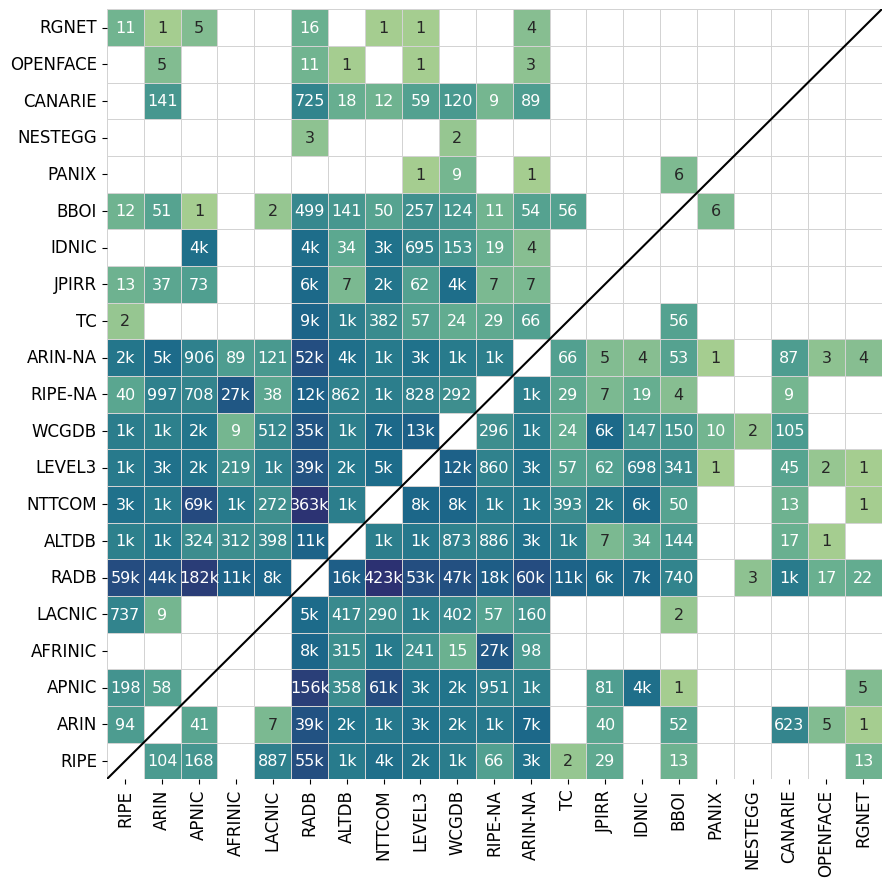

In [5]:
# Heatmap 2
plt.figure(figsize=(10,10))
ax = sns.heatmap(imatrix2, annot=annot2,fmt="", cmap=cmap1, vmin=0, vmax=290000, cbar=False, linecolor='lightgrey', linewidths=0.5, annot_kws={'size': 11.5}, xticklabels=categories, yticklabels=categories, norm=LogNorm())
ax.invert_yaxis()
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)
plt.plot([0,21], [0,21], 'k-')
plt.savefig('denom.eps', bbox_inches='tight')